In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

In [2]:
@np.vectorize
def fakesine(x):
    x = x - np.round(x)
    z = 2*x
    y = -z*np.abs(z) + z
    return 4.0 * y

def chebyshev_sine(x, A, dtype=np.float64):
    N = len(A)
    x = x.astype(dtype)
    x = x - np.round(x)
    z = x*x;      
    g = A[N-1]
    for i in reversed(range(0,N-1)):
        g = g*z + A[i]
    return g * (z-0.25) * x

# Calculated from "src/derive_horner_polynomial.cpp"
chebyshev_An = {
    6: [-25.132741114356,64.83582660260,-67.076885208351,38.499981514800,-14.073700104607,3.208624097047],
    5: [-25.132732845273,64.83488763838,-67.048284786467,38.156095874949,-12.312534217334],
    4: [-25.13228423125947,64.79915794130062,-66.31927142803774,32.87957897850996],
    3: [-25.11616846707109,63.95266775422110,-56.16687858484016],
    2: [-24.73853950569869,53.17058702969315],
    1 : [-20.58612380812712],
}

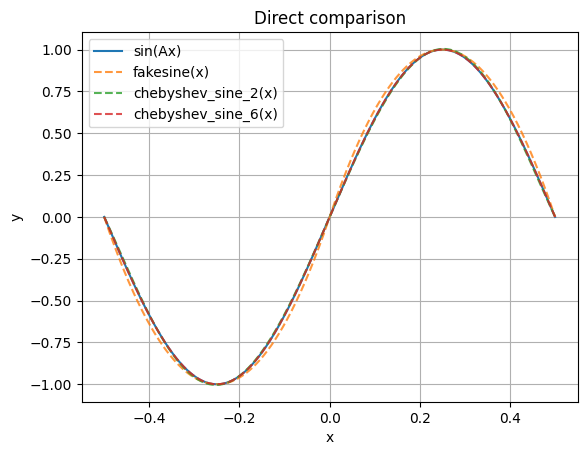

In [3]:
# Direct side by side comparison
N = 1024
X = np.linspace(-0.5,0.5,N)
y_target = np.sin(2*np.pi*X)
y_fake = fakesine(X)
y_chebyshev = {n: chebyshev_sine(X, coefficients) for (n, coefficients) in chebyshev_An.items()}

plt.figure()
plt.plot(X, y_target, label="sin(Ax)")
plt.plot(X, y_fake, label="fakesine(x)", alpha=0.8, linestyle="--")
#for n in sorted(y_chebyshev.keys()):
for n in (2,6):
    y = y_chebyshev[n]
    plt.plot(X, y, label=f"chebyshev_sine_{n}(x)", alpha=0.8, linestyle="--")
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Direct comparison")
plt.legend()

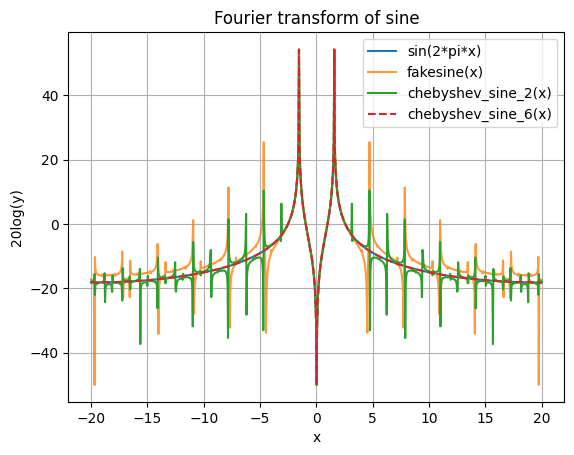

In [4]:
# Compare Fourier transforms
N = 1024
X = np.linspace(-20,20,N) # make harmonics more visible
y_target = np.sin(2*np.pi*X)
y_fake = fakesine(X)
y_chebyshev = {n: chebyshev_sine(X, coefficients) for (n, coefficients) in chebyshev_An.items()}

def calc_fft_mag(x):
    y = np.fft.fftshift(x)
    y = 20.0*np.log10(np.abs(y))
    y[y<-50] = -50 # clamp
    return y
Y_target = calc_fft_mag(np.fft.fft(y_target))
Y_fake = calc_fft_mag(np.fft.fft(y_fake))
Y_chebyshev = {n: calc_fft_mag(np.fft.fft(y)) for (n,y) in y_chebyshev.items()}

plt.plot(X, Y_target, label="sin(2*pi*x)")
plt.plot(X, Y_fake, label="fakesine(x)", alpha=0.8)
# for n in sorted(Y_chebyshev.keys()):
#     plt.plot(X, Y_chebyshev[n], label=f"chebyshev_sine_{n}(x)", alpha=0.8, linestyle="--")
plt.plot(X, Y_chebyshev[2], label=f"chebyshev_sine_{2}(x)")
plt.plot(X, Y_chebyshev[6], label=f"chebyshev_sine_{6}(x)", linestyle="--")
plt.grid(True)
plt.title("Fourier transform of sine")
plt.ylabel("20log(y)")
plt.xlabel("x")
plt.legend()

  N    f32 mae    f64 mae
---  ---------  ---------
  1  8.215e-02  8.215e-02
  2  4.894e-03  4.894e-03
  3  1.685e-04  1.685e-04
  4  3.790e-06  3.789e-06
  5  6.984e-08  5.982e-08
  6  3.746e-08  7.066e-10


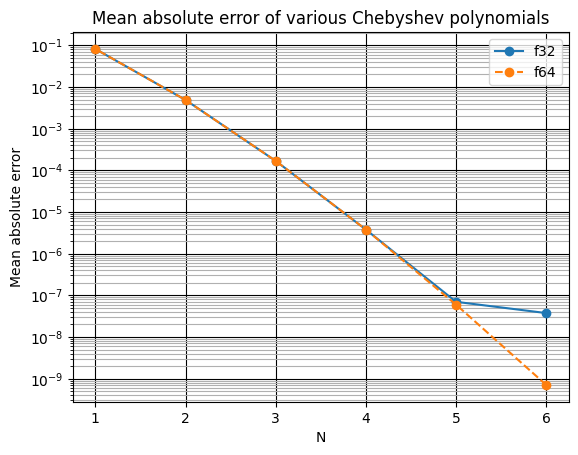

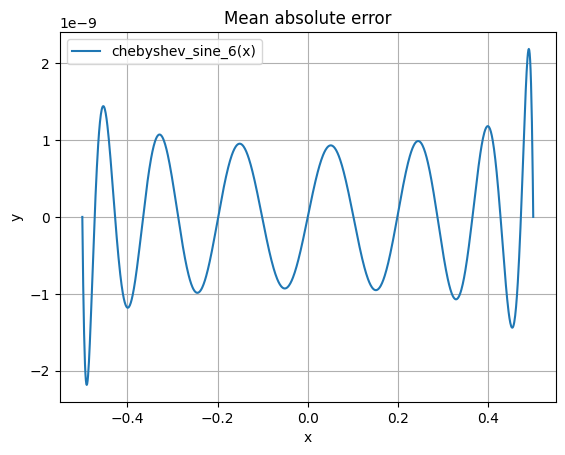

In [5]:
# Plot mean absolute error for Chebyshev approximations
N = 1024
X = np.linspace(-0.5,0.5,N)
y_target = np.sin(2*np.pi*X)
y_chebyshev_f64 = {n: chebyshev_sine(X, coefficients, dtype=np.float64) for (n, coefficients) in chebyshev_An.items()}
y_chebyshev_f32 = {n: chebyshev_sine(X, coefficients, dtype=np.float32) for (n, coefficients) in chebyshev_An.items()}
# Calculated from "src/derive_horner_polynomial.cpp"
# Use solutions for N=5,6 which have been optimised for f32
chebyshev_A6_f32 = np.array([-25.1327419281,64.8358230591,-67.0768585205,38.5037078857,-14.1102266312,3.2983388901], dtype=np.float32)
chebyshev_A5_f32 = np.array([-25.1327323914,64.8348770142,-67.0481109619,38.1546096802,-12.3083391190], dtype=np.float32)
y_chebyshev_f32[6] = chebyshev_sine(X, chebyshev_A6_f32, dtype=np.float32)
y_chebyshev_f32[5] = chebyshev_sine(X, chebyshev_A5_f32, dtype=np.float32)
y_mae_f64 = {n: np.abs(y_target-y).mean() for n,y in y_chebyshev_f64.items()}
y_mae_f32 = {n: np.abs(y_target-y).mean() for n,y in y_chebyshev_f32.items()}

table_rows = [(n, y_mae_f32[n], y_mae_f64[n]) for n in sorted(y_mae_f32.keys())]
print(tabulate(table_rows, headers=["N", "f32 mae", "f64 mae"], floatfmt=".3e"))

plt.figure()
plt.plot(y_mae_f32.keys(), y_mae_f32.values(), marker="o", label="f32")
plt.plot(y_mae_f64.keys(), y_mae_f64.values(), marker="o", label="f64", linestyle="--")
plt.xlabel("N")
plt.ylabel("Mean absolute error")
plt.yscale("log")
plt.title("Mean absolute error of various Chebyshev polynomials")
plt.grid(True, which="major", color="black")
plt.grid(True, which="minor")
plt.legend()
    
plt.figure()
for n in (6,):
    y = y_chebyshev_f64[n]
    y_error = y_target - y
    plt.plot(X, y_error, label=f"chebyshev_sine_{n}(x)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Mean absolute error")
plt.grid(True)
plt.legend()